# COMP5318/COMP4318 Week 8: Convolutional Neural Networks and Recurrent Neural Networks

While the multilayer perceptron networks from the previous lab can be very powerful, they have limitations on particular tasks. 

In an MLP trained on an image task, we learn weights between every input neuron (eg. every pixel position) and the neurons in the next layer. However, if we wish to detect features of different sizes, angles and positions in the image, it can be difficult to learn weights for each input pixel position. Moreover, using fully connected layers quickly leads to an explosion in the number of parameters in the network as the input image size grows.

Today, we will introduce the implementation of basic convolutional neural networks (CNNs), which are deep neural networks specifically designed to better capture spatial relationships between regions of neigbouring pixels and extract features from images in a manner loosely inspired by the visual cortex.

MLPs are also not optimised to handle sequence data, since they process all inputs in the same manner without any distinction of order. In the second part of today's lab, we will introduce the implementation of recurrent neural networks (RNNs) which are specifically designed to process temporal data.

## 1. Setup
We begin by importing some packages used throughout the notebook and setting up our plotting environment.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import time

# Import our deep learning libraries which were installed last week
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

# Make the notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_image(image):
    # Remove redundant extra dimension
    if image.shape[-1] == 1:
        image = image.squeeze(axis=-1)
        
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    # Remove redundant extra dimension
    if image.shape[-1] == 1:
        image = image.squeeze(axis=-1)
        
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of images which are encoded as numpy arrays."""
    
    # Remove redundant extra dimension
    if data.shape[-1] == 1:
        data = data.squeeze(axis=-1)
        
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

## 2. Convolutional Neural Network using Keras

To introduce you to the implementation of convolutional neural networks using Keras, we will begin by solving the now familiar [MNIST](http://yann.lecun.com/exdb/mnist/) problem. This will give us a useful point of comparison to the MLP we used on this task last week. Also, a small network will suffice for this task, which is important when we wish to run the lab on our local hardware where GPUs may not be available.

### Data loading and preprocessing
Let's begin with the same data preparation steps as last week, condensed into the following cell:

In [2]:
# Load the MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

# Scale the data to the range 0-1
X_train_full = X_train_full / 255.
X_test = X_test / 255.

# Create validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9)

print(f"Shape of X_train: {X_train.shape}")

Shape of X_train: (54000, 28, 28)


Last week, we flattened each image into a vector before feeding it to the MLP. However, for input to CNNs we usually keep the original image dimensions intact since they will extract features from neighbouring pixel regions. 

In fact, most standard CNNs expect a 4 dimensional array as input:
```(batch_size, width, height, n_channels)```

The final dimension, ```n_channels```, corresponds to the number of values per image pixel. RGB colour images typically have three channels, with a value for the intensity of red, green, and blue primary colours. Combining these values can produce a broad array of colours.

Recall that MNIST images are greyscale, so we only have one value per image pixel. While this makes the extra dimension somewhat redundant, our model will still expect it in the input. Let's add it using ```np.expand_dims```.

In [3]:
# Add an extra dimension to our data
X_train = np.expand_dims(X_train, -1)
X_valid = np.expand_dims(X_valid, -1)
X_test = np.expand_dims(X_test, -1)

print(f"New shape of X_train: {X_train.shape}")

New shape of X_train: (54000, 28, 28, 1)


### A note on CNN architecture design

Now that our data is prepared appropriately for input to a CNN, it is time to design our model.

The problem of model design is no less difficult for CNNs than for MLPs. In fact, we introduce more possible decisions, as each convolutional layer has different possible number of filters, kernel sizes, strides, and padding. Additionally, modern CNNs are often very deep networks with more layers than are practically possible for MLPs.

For problems where deep CNNs are required, it is common to use existing architectures as a starting point rather than design your own. These architectures have often been developed from extensive experimentation, and relieve a lot of the design burden, often requiring just some slight changes to the input or output layers to be fully functional on your dataset. You can find a variety of different architectures which differ in complexity, runtime, and performance. Several now classic architectures for image classification include:
- [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
- [VGG](https://arxiv.org/pdf/1409.1556.pdf)
- [ResNet](https://arxiv.org/abs/1512.03385)

Keras implementations for each are available from various sources, or you could try define your own from the papers!

### Defining our CNN model
These existing models have many layers and require a GPU to run efficiently. Instead, we will define a small, simple CNN which can run on our local hardware more efficiently, and still perform excellently at the MNIST problem.

Let's define the model now using ```keras.Sequential``` and then we will unpack each component.

In [4]:
model = keras.Sequential([
    
    # Specify the input shape
    keras.Input(shape=(28, 28, 1)),
    
    # Conv and pool block 1
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Conv and pool block 2
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten and classify using dense output layer
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

- __*Input layer*__

For this model, we don't need to flatten the data at the beginning of the network. However, we use this layer to specify the expected input size, so that Keras can deduce the parameters in the rest of the model.

- __*Convolutional layers*__

These are the most important components of the CNN, and account for its name. 

As a brief recap, rather than being connected to every pixel in the input image, neurons in the first convolutional layer are connected to a small region of neighbouring pixels (their receptive field). Thus the output of these neurons is determined by low-level features picked up by the weights connected to its receptive field. 

In fact, we typically reuse multiple sets of weights for every neighbourhood of pixels to detect different features across the image. These sets of weights are called kernels or filters, and after training they will learn to pick up different features, such as lines and curves in the first conv layer. 

The next convolutional layer performs the same process, but will assemble the information about these low-level features to detect higher level features such as shapes. This hierarchical structure is loosely inspired by research into the visual cortex ([for the interested reader](https://www.nobelprize.org/prizes/medicine/1981/summary/)).

Since each filter is applied to various regions in the image, we typically think about it striding across the input. The regions covered and number of neurons in the next layer are determined by the size of the kernel, the size of the strides we take, and the padding used around the borders of the input.

The following gifs may help understand the concept:


![Convolution_arithmetic_-_Padding_strides_odd.gif](https://upload.wikimedia.org/wikipedia/commons/2/2d/Convolution_arithmetic_-_Padding_strides_odd.gif)(Vincent Dumoulin, Francesco Visin, [MIT Licence <http://opensource.org/licenses/mit-license.php>], via Wikimedia Commons)

![2D_Convolution_Animation.gif](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)(Michael Plotke, [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0), via Wikimedia Commons)

The Keras documentation for the ```Conv2D``` layer is located [here](https://keras.io/api/layers/convolution_layers/convolution2d/). We must specify the number of filters and the kernel size, as we have done above. Changing the stride and padding is also possible, however these are set to reasonable default values.

Understanding the convolution operation can be difficult. For those interested in a more thorough explanation, there exist countless excellent tutorials online, and you may consult one of the course textbooks such as *Aurelien Geron (2019). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.* Chapter 14, which is available online from the University library.

- __*Pooling layers*__

To reduce the number of parameters in the network, these layers downsample dimensions by taking the max value over input windows defined by ```pool_size```.

- __*Fully connected classifier*__

After the features of the image have been appropriately extracted by the convolutional blocks of the network, we flatten everything and use a fully connected classifier to produce probabilities over the classes.

Note that with only one fully connected layer, our overall number of parameters is much lower than for the MLP we used last week!

### Specifying the optimiser and loss function
While a thorough treatment of different deep learning optimisers is beyond the scope of this course, today we will utilise the Adam optimiser ([paper](https://arxiv.org/abs/1412.6980)) ([Keras docs](https://keras.io/api/optimizers/adam/)), which extends on regular SGD by adapting the learning rates for individual parameters throughout training. Having these adaptive learning rates can greatly speed up our training process, and removes some of the importance of tuning the initial learning rate. 


As per last week, our labels are in index form rather than encoded as one-hot vectors. Hence, we utilse Keras' ```sparse_categorical_crossentropy``` loss.

In [6]:
# Compile model with loss, optimiser, and metrics
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Training and evaluating the model


The following training cell may take several minutes to run depending on your hardware. Even though there are less parameters than last week, these convolutional layers take a lot of computation! If you're pressed for time, you can just examine the outputs.

In [7]:
"""Running this cell could take several minutes"""

# Train the model for 10 epochs with batch size 128
batch_size = 128
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/10
422/422 [==============================] - 22s 52ms/step - loss: 0.3637 - accuracy: 0.8896 - val_loss: 0.0990 - val_accuracy: 0.9733
Epoch 2/10
422/422 [==============================] - 25s 59ms/step - loss: 0.1124 - accuracy: 0.9660 - val_loss: 0.0670 - val_accuracy: 0.9822
Epoch 3/10
422/422 [==============================] - 28s 66ms/step - loss: 0.0843 - accuracy: 0.9737 - val_loss: 0.0523 - val_accuracy: 0.9858
Epoch 4/10
422/422 [==============================] - 26s 62ms/step - loss: 0.0688 - accuracy: 0.9788 - val_loss: 0.0468 - val_accuracy: 0.9862
Epoch 5/10
422/422 [==============================] - 22s 53ms/step - loss: 0.0616 - accuracy: 0.9814 - val_loss: 0.0423 - val_accuracy: 0.9882
Epoch 6/10
422/422 [==============================] - 21s 50ms/step - loss: 0.0543 - accuracy: 0.9830 - val_loss: 0.0405 - val_accuracy: 0.9887
Epoch 7/10
422/422 [==============================] - 24s 58ms/step - loss: 0.0499 - accuracy: 0.9846 - val_loss: 0.0396 - val_accuracy:

In [8]:
# Evaluate the classifier on the test data.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.0281 - accuracy: 0.9905
Accuracy on test data: 0.9905


[0 4 1]


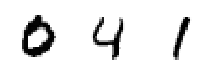

In [9]:
# Sample several test examples
X_test_sample = X_test[3:6]

# Get probability of each class from model
y_proba = model.predict(X_test_sample)
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)

plot_examples(X_test[3:], n_rows=1, n_cols=3)

Using an MLP on this task, we hit a barrier around 98% accuracy. With the improvements in image feature extraction from CNNs, we have slightly improved our performance, even while using fewer parameters. On more difficult tasks where the images are not centred and size-normalised, the improvement is usually more pronounced.

Towards the end of the notebook is a task where you will have a chance to apply a CNN to a more difficult classification problem with colour images.

## 3. LSTM using Keras

Now let's look at a task which requires sequence processing, and solve it by implementing a type of recurrent neural network using Keras.

The [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) contains movie reviews written by users of the IMDB website, labelled by positive or negative sentiment. While not as simple as the MNIST image task, it has become somewhat of a benchmark dataset for recurrent networks.

While we could try and solve this task without considering the order of the words and how close they are to each other, using RNNs allows us to capture the subtlety of phrases such as 'not good'.

### Data loading, exploration and preprocessing

Let's load the dataset from Keras ([documentation](https://keras.io/api/datasets/imdb/)). The purpose of the arguments we passed to ```load_data``` will be described below.

In [10]:
# Specify first index for words
INDEX_FROM = 3

# Include this number of the most common words in our vocabulary
NUM_WORDS = 10000

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.imdb.load_data(
    num_words=NUM_WORDS,
    start_char=1,
    oov_char=2,
    index_from=INDEX_FROM,
)

Let's first check out the shape of the data we have loaded.

In [11]:
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (25000,)
Shape of y_train_full: (25000,)
Shape of X_test: (25000,)
Shape of y_test: (25000,)


We have 25000 training and testing examples. However, it seems a bit strange that our data is one dimensional. Let's investigate this by looking at the first training example.

In [12]:
print(X_train_full[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


Our numpy arrays only have one dimension because each example is encoded as a list! The reason is that the reviews may have different lengths, and numpy arrays have a fixed shape in each dimension. Let's look at the length of another review.

In [13]:
print(X_train_full[5])

[1, 778, 128, 74, 12, 630, 163, 15, 4, 1766, 7982, 1051, 2, 32, 85, 156, 45, 40, 148, 139, 121, 664, 665, 10, 10, 1361, 173, 4, 749, 2, 16, 3804, 8, 4, 226, 65, 12, 43, 127, 24, 2, 10, 10]


- ***Data encoding***

Another thing that may be foreign is the data encoding. Wasn't this meant to be a text dataset? 

In fact, the dataset comes preprocessed for use. It has been split into words with punctuation removed, and each unique word has been assigned an integer. The integers are assigned to the words in order of frequency, so the most common words are represented by the smallest numbers.

When we loaded the data, we also specified that each example will begin with the 'start character' 1, and any words which don't belong to our chosen vocabulary of the 10000 most common words will be represented by an 'out of vocab character' 2.

Not to fear: to better understand the dataset and recover the text, Keras includes a function to load a mapping from words to their indices, with just some minor processing requried to account for our special characters.

In [14]:
# Load dictionary mapping words to indices
word_to_index = tf.keras.datasets.imdb.get_word_index()

# Account for the start and out of vocab characters
word_to_index = {k : (v+3) for (k, v) in word_to_index.items()}
word_to_index["<PAD>"] = 0
word_to_index["<START>"] = 1
word_to_index["<UNK>"] = 2
word_to_index["<UNUSED>"] = 3

In [ ]:
# Display the dictionary
word_to_index

In [16]:
# Examine some common words
print(f"Index for 'the': {word_to_index['the']}")
print(f"Index for 'good': {word_to_index['good']}")
print(f"Index for 'dog': {word_to_index['dog']}")

Index for 'the': 4
Index for 'good': 52
Index for 'dog': 912


To actually decode a sequence, we need to map in the opposite direction: from indices to words.

In [17]:
# Get a dictionary mapping indices to words
index_to_word = dict((i, word) for (word, i) in word_to_index.items())

Finally, we are ready to examine some of these reviews to get an idea of the task our model must solve.

In [18]:
def decode_imdb_sequence(example):
    return " ".join(index_to_word[i] for i in example)

decode_imdb_sequence(X_train_full[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [19]:
decode_imdb_sequence(X_train_full[5])

"<START> begins better than it ends funny that the russian submarine crew <UNK> all other actors it's like those scenes where documentary shots br br spoiler part the message <UNK> was contrary to the whole story it just does not <UNK> br br"

Before using sequences of integers as input to our model, it is appropriate to standardise the sequence length by padding shorter sequences and chopping off the end of very long sequences, which allows us to convert our input to a multidimensional numpy array. Keras provides this functionality in a preprocessing library.

In [20]:
# Pad/truncate sequences to length of 100
X_train_full = keras.preprocessing.sequence.pad_sequences(X_train_full, maxlen=100)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=100)

In [21]:
X_train_full.shape

(25000, 100)

Data preprocessing can have a huge impact on performance in natural language tasks, and is typically a more involved process than for images with many options beyond what we have used here. For production tasks, it is advisable to tune your text preprocessing just as you would the parameters of your model.

### Creating a validation set

As usual when dealing with neural networks, it will be helpful to have a validation set.

In [22]:
# Create validation set from 10% of the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9)

### Defining our LSTM model

Recall from the lecture that the idea behind recurrent models is to process inputs sequentially, updating a state vector by applying the same weights to each new input. Vanilla RNNs have problems encoding long sequences: eventually after many updates the gradients can grow very large, and the state vector may not properly encode the information from the earlier inputs.

Since we are dealing with long sequences in this dataset, we will utilise a Long Short Term Memory network instead. As we covered in the lecture, this contains a more sophisticated system of 'gates' to update the hidden state vector without neglecting the information from much earlier in the sequence.

Implementing recurrent models using Keras' Sequential API couldn't be easier:

In [23]:
# Implement a simple, single layer LSTM model
model = keras.models.Sequential([
    
    # Embedding layer maps words to dense vectors
    keras.layers.Embedding(NUM_WORDS, 64),
    
    # LSTM layer with 64 units
    keras.layers.LSTM(64),
    
    # Fully connceted layer performs classification on the LSTM output
    keras.layers.Dense(1, activation="sigmoid")
])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


- ***Embedding layer***

Rather than input indices directly to the LSTM, we first map the indices to vectors of size 64 which represent the word. These vectors are called embeddings and achieveing the best embeddings, or ones with particular properties, is a significant focus in Natural Language Processing. Here, we simply delegate this task to a trainable matrix of weights, so the embeddings will be trained along with the other components of our model.

- ***LSTM***

This is the core of our recurrent model. There are several gates which all have particular roles to play in appropriately processing the sequence. Briefly, a forget gate controls which parts of the long-term state to erase, an input gate controls which parts of the input to add to the long-term state, and an output gate determines which parts of the long-term state should be output at each time step.

For a more thorough explanation, you may wish to consult the lecture or one of the course textbooks such as *Aurelien Geron (2019). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.* Chapter 14, which is available online from the University library.

- ***Fully connected classifier***

Our final layer processes the LSTM output and produces a single output value, which is passed through a sigmoid function since our task is binary classification into positive and negative review sentiment.

### Specifying the loss and optimiser
We will again use the Adam optimiser to speed up convergence.

Our loss function will be ```binary_crossentropy``` since we are doing binary classification. If you like, refer to the documentation [here](https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function) to check the expected model outputs and labels.

In [25]:
# Compile the model, specifying optimsier, loss and metrics
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

The following training cell may take several minutes to run depending on your hardware. If you're pressed for time, you can just examine the outputs.

Can you notice any trend as training progresses?

In [26]:
"""Running this cell could take several minutes"""

# Train the model for 3 epochs
model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
704/704 [==============================] - 37s 51ms/step - loss: 0.4238 - accuracy: 0.8016 - val_loss: 0.3542 - val_accuracy: 0.8548
Epoch 2/3
704/704 [==============================] - 40s 57ms/step - loss: 0.2569 - accuracy: 0.8984 - val_loss: 0.3559 - val_accuracy: 0.8428
Epoch 3/3
704/704 [==============================] - 48s 69ms/step - loss: 0.1800 - accuracy: 0.9312 - val_loss: 0.4338 - val_accuracy: 0.8352


Not all sequential models have a single recurrent layer, and it is easy to stack multiple recurrent layers one after the other. Even making layers which process the sequence in both directions is a breeze in Keras. Creating other types of models is as simple as modifying the layers in the model definition. For example:

A two-layer bidirectional LSTM:

```model = keras.models.Sequential([
    keras.layers.Embedding(NUM_WORDS, 64),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(1, activation="sigmoid")
])```

A simple RNN:

```model = keras.models.Sequential([
    keras.layers.Embedding(NUM_WORDS, 64),
    keras.layers.SimpleRNN(64)
    keras.layers.Dense(1, activation="sigmoid")
])```

## 4. Task - Create a CNN for CIFAR-10

For today's task, we will introduce another classic image classification dataset called CIFAR-10. The CIFAR-10 dataset contains 600000 32x32 RGB images of 10 classes of common objects. There is an equal number of images from each class, and a 50000/10000 train/test split.

Let's load the data using Keras ([documentation](https://keras.io/api/datasets/cifar10/)). Since there is a significant number of images, this may take a minute.

In [27]:
# Load CIFAR 10 dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [28]:
# Scale the data to the range 0-1
X_train_full = X_train_full / 255.
X_test = X_test / 255.

# Create validation set from the training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9)

Note there are 3 colour channels for each pixel, corresponding to the red, green, and blue values:

In [29]:
X_train.shape

(45000, 32, 32, 3)

Let's take a look at some examples from the dataset. Can you spot what some of the classes might be?

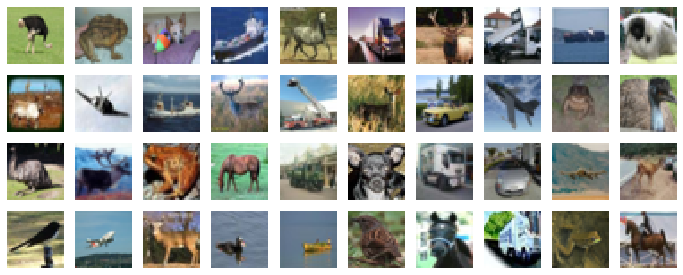

In [30]:
plot_examples(X_train)

You can check out a description of the dataset from its creators [here](https://www.cs.toronto.edu/~kriz/cifar.html). Using this, we can get an ordered list of the labels, which you may find useful to check your model's predictions.

In [31]:
cifar10_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

### Task
Define, train and evaluate a CNN for the CIFAR10 problem. 

You can inspire your solution from the simple CNN we have already used for MNIST, or, if you are feeling ambitious, feel free to define a deeper CNN which you could base on one of the well-known architectures mentioned above ([AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), [VGG](https://arxiv.org/pdf/1409.1556.pdf), [ResNet](https://arxiv.org/abs/1512.03385)). 

For those of you who are already more comfortable with Keras and looking to strengthen your skills, an extension would be to chase the best performance possible by importing a pretrained Keras model from ```keras.applications``` ([documentation](https://keras.io/api/applications/)) and modifying it for the CIFAR10 task.

A note on training time: a small CNN like the one we used for MNIST above will take about 30 seconds per epoch to train on modest, non-GPU hardware. If you are itching to try out deeper models and don't have GPU access, you can try uploading this notebook to [Google Colaboratory](https://colab.research.google.com) and change the runtime type to GPU, as mentioned in last week's tutorial. 

### Solution
Following is a simple solution using a similar model architecture as the earlier section. Feel free to be more creative with your solution to achieve a higher accuracy!

In [32]:
model = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

# Compile model with loss, optimiser, and metrics
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# Train the model for 20 epochs with batch size 128
batch_size = 128
epochs = 20
history = model.fit(X_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/20
352/352 [==============================] - 27s 75ms/step - loss: 1.7249 - accuracy: 0.3817 - val_loss: 1.4439 - val_accuracy: 0.4953
Epoch 2/20
352/352 [==============================] - 28s 80ms/step - loss: 1.4003 - accuracy: 0.5042 - val_loss: 1.2828 - val_accuracy: 0.5537
Epoch 3/20
352/352 [==============================] - 34s 96ms/step - loss: 1.2820 - accuracy: 0.5501 - val_loss: 1.1665 - val_accuracy: 0.5982
Epoch 4/20
352/352 [==============================] - 35s 99ms/step - loss: 1.2123 - accuracy: 0.5747 - val_loss: 1.1116 - val_accuracy: 0.6230
Epoch 5/20
352/352 [==============================] - 34s 98ms/step - loss: 1.1569 - accuracy: 0.5955 - val_loss: 1.0692 - val_accuracy: 0.6381
Epoch 6/20
352/352 [==============================] - 29s 83ms/step - loss: 1.1126 - accuracy: 0.6131 - val_loss: 1.0833 - val_accuracy: 0.6323
Epoch 7/20
352/352 [==============================] - 32s 90ms/step - loss: 1.0748 - accuracy: 0.6265 - val_loss: 1.0307 - val_accuracy:

## 5. Summary

Today has provided a simple introduction into the rich and complex world of CNNs and RNNs, which have become immensely popular in recent years. CNNs and RNNs can also be used for a wide variety of image and sequence-based tasks, including image segmentation, language generation, and machine translation, just to name a few.   

In [ ]:
# CNN summary
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax"),
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

history = model.fit(train_generator, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_valid, y_valid))

# RNN/LSTM summary
model = keras.models.Sequential([
    keras.layers.Embedding(NUM_WORDS, 64),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

model.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_valid, y_valid))

## Acknowledgements

This tutorial is based on:

Aurelien Geron (2022). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.

François Chollet (2021). Simple MNIST convnet, Keras code examples https://keras.io/examples/vision/mnist_convnet/ [web]